In [41]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from Grafidi import WFGraph as WF
from Grafidi import Graph as GR
import scipy.optimize as sco
import scipy.sparse as scs
from IPython.display import FileLink
import matplotlib.cm as cm
plt.rcParams['figure.figsize']=[4,(3/4)*4]

In [42]:
# Nehari projection

def NehaProj(u):
    return u * ( ( (-WF.Lap(u).dot(u) + WF.norm(u, 2)**2) / (WF.norm(u, 4) ** (4)) ) ** (1/2) )

# Gradient descent

def NehariGrad(u, tau, epsilon, itermax):
    
    M_1 = g.Id - tau * (g.Lap - g.Id)
    n = 0
    l = []
    
    for n in range(itermax):
        
        u_old = u
        M = M_1 - tau * g.Diag(abs(u) ** 2)
        u = NehaProj(WF.Solve(M, u))
        n += 1
        
        err = WF.norm(u - u_old, 2) / WF.norm(u_old, 2)
        l.append(err)
        if err < epsilon:
            break
    
    return u, n

In [43]:
# Parameters omega, gamma and L

omega = 1
gamma = 1 / 2
Length = [0.1, 0.25, 0.75, 2]

# Other parameters

L_inf = 50
tau = 0.1
epsilon = 1e-7
itermax = 500

In [44]:
# Computation of the ground state and phase portrait

P = []
Q = []

for L in Length:
    
    # Graph construction
    
    g_list=[f"C A {{'Length':{L_inf},'Line':'S','Id':'0'}}",
            f"A B {{'Length':{L},'Line':'C','Id':'0'}}",
            f"B A {{'Length':{L},'Line':'C','Id':'0'}}"]
    g_nx = nx.parse_edgelist(g_list, create_using=nx.MultiDiGraph())
    N_Edges = g_nx.size()
    bc = {}
    bc['C'] = ['Dirichlet']
    bc['A'] = ['Delta', -gamma]
    bc['B'] = ['Kirchoff']
    N = 10000
    g = GR(g_nx, N, bc)
    NewPos={'C':[-g.Edges[('C','A','0')]['L'], 0], 'A':[0, 0], 'B':[L / np.pi, 0]}
    GR.Position(g, NewPos)
    
    # Initial datum
    
    fun = {}
    fun[('A', 'B', '0')] = lambda x: np.sin(x * np.pi / (L * 2))
    fun[('B', 'A', '0')] = lambda x: np.cos(x * np.pi / (L * 2))
    fun[('A', 'C', '0')] = lambda x: 0
    Psi = WF(fun, g)
    Psi = (Psi / WF.norm(Psi, 2))
    #WF.draw(Psi)
    
    # Computation of the ground state
    
    GS, niter = NehariGrad(Psi, tau, epsilon, itermax)
    #print(niter)
    
    # Values of the ground state at the vertex

    dx = g.Edges[('A', 'B', '0')]['dx']
    n0 = g.Edges[('A', 'B', '0')]['Indexes'][0]
    
    p0 = GS.vect[n0]
    P.append(p0)
    
    n1 = g.Edges[('A', 'B', '0')]['Indexes'][0] + 1
    p1 = GS.vect[n1]
    q = (p1 - p0) / dx
    Q.append(q)

Edge not found
Edge not found
Edge not found
Edge not found


<IPython.core.display.Javascript object>


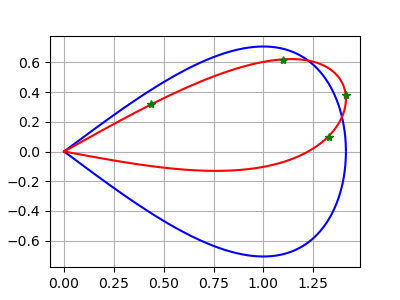

In [45]:
# Plot of the phase portrait

x = np.linspace(0, np.sqrt(2 * omega), 100001)

plt.figure()

plt.plot(x, np.sqrt(x ** 2 * (omega - (x ** 2) / 2)), color='blue')
plt.plot(x, -np.sqrt(x ** 2 * (omega - (x ** 2) / 2)), color='blue')

plt.plot(x, (x / 2) * (gamma + np.sqrt(omega - (x ** 2) / 2)), color='red')
plt.plot(x, (x / 2) * (gamma - np.sqrt(omega - (x ** 2) / 2)), color='red')

plt.plot(P, Q, '*', color='green')

plt.grid()
plt.show()

filename = "tadpole_gs_1.pdf"
plt.savefig(filename)

<IPython.core.display.Javascript object>


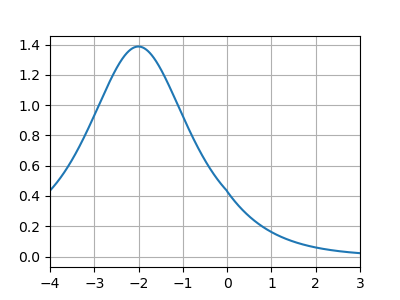

In [46]:
# Plot of the last ground state computed

plt.figure()

GS.vect = GS.vect[::-1]
plt.plot(np.linspace(-2 * L, L_inf, len(GS.vect)), GS.vect)

plt.xlim((-2 * L, 3))
plt.grid()
plt.show()

filename = "tadpole_gs_3.pdf"
plt.savefig(filename)